In [15]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Constants
M = 1.022  # o-Ps mass in MeV
min_energy = 0.001 * M / 2
alpha = 1/137  # Fine structure constant
m_e = 0.511  # Electron mass in MeV

def dalitz_density(e1, e2, e3, k1, k2, k3, S=np.array([0,0,1]), loops=False, polarized=True):
    z = M - e1 - e2
    if e1 < min_energy or e2 < min_energy or z < min_energy or e1 >= M/2 or e2 >= M/2 or z >= M/2:
        return 0.0

    term1 = ((M/2 - e1)**2) / (e2**2 * z**2 + 1e-10)
    term2 = ((M/2 - e2)**2) / (e1**2 * z**2 + 1e-10)
    term3 = ((M/2 - z)**2) / (e1**2 * e2**2 + 1e-10)
    unpol = term1 + term2 + term3

    density = unpol
    if loops:
        s12 = max(2 * (e1 * e2 - np.dot(k1, k2)), m_e**2 + 1e-6)
        s13 = max(2 * (e1 * e3 - np.dot(k1, k3)), m_e**2 + 1e-6)
        s23 = max(2 * (e2 * e3 - np.dot(k2, k3)), m_e**2 + 1e-6)
        m2 = m_e**2

        log12 = np.log(s12 / m2)
        log13 = np.log(s13 / m2)
        log23 = np.log(s23 / m2)
        A1 = (1 / (s12 * s13)) * (log12 - log13) + (alpha / np.pi)
        A2 = (1 / (s23 * s13)) * (log23 - log13) + (alpha / np.pi)
        A3 = (1 / (s12 * s23)) * (log12 - log23) + (alpha / np.pi)

        M_sq = max(2 * (A1**2 * s23**2 + A2**2 * s13**2 + A3**2 * s12**2) - (A1 * A2 * s12 * s13 * s23 / m2), 0.0)
        density = M_sq

    if polarized:
        cross = np.cross(k1, k2)
        norm_cross = np.linalg.norm(cross)
        if norm_cross > 0:
            pol_term = np.dot(S, cross / norm_cross) * (0.05 if not loops else (alpha / np.pi) * 0.01)
            density *= (1 + pol_term)

    return density

def sample_single(loops, polarized, S, max_d):
    x = min_energy + np.random.uniform(0,1) * (M / 2 - min_energy)
    y = min_energy + np.random.uniform(0,1) * (M / 2 - min_energy)
    z = M - x - y
    if z <= min_energy or z >= M/2: return None

    # Sample directions (k = E * dir)
    cost = 2 * np.random.uniform(0,1) - 1
    sint = np.sqrt(1 - cost**2)
    phi = 2 * np.pi * np.random.uniform(0,1)
    dir1 = np.array([sint * np.cos(phi), sint * np.sin(phi), cost])
    k1 = x * dir1

    cos_theta12 = (z**2 - x**2 - y**2) / (2 * x * y)
    cos_theta12 = np.clip(cos_theta12, -1, 1)
    sin_theta12 = np.sqrt(1 - cos_theta12**2)
    phi2 = 2 * np.pi * np.random.uniform(0,1)
    dir2 = np.array([sin_theta12 * np.cos(phi2), sin_theta12 * np.sin(phi2), cos_theta12])

    # Rotate dir2 around dir1 (proper rotation matrix)
    u = dir1 / np.linalg.norm(dir1)
    a = np.cos(phi2)
    b = np.sin(phi2)
    rot = np.array([[a + u[0]**2 * (1 - a), u[0] * u[1] * (1 - a) - u[2] * b, u[0] * u[2] * (1 - a) + u[1] * b],
                    [u[1] * u[0] * (1 - a) + u[2] * b, a + u[1]**2 * (1 - a), u[1] * u[2] * (1 - a) - u[0] * b],
                    [u[2] * u[0] * (1 - a) - u[1] * b, u[2] * u[1] * (1 - a) + u[0] * b, a + u[2]**2 * (1 - a)]])
    dir2 = rot @ dir2  # Apply rotation
    k2 = y * dir2
    k3 = -k1 - k2

    d = dalitz_density(x, y, z, k1, k2, k3, S=S, loops=loops, polarized=polarized)
    if np.random.uniform(0, max_d) < d:
        E_shuffle = np.array([x, y, z])
        np.random.shuffle(E_shuffle)
        return (E_shuffle[0]/M, E_shuffle[1]/M)

    return None

def sample_dalitz(n_samples=10000, loops=False, polarized=False, S=np.array([0,0,1]), num_threads=20):
    # Probe max_d
    max_d = 0.0
    for i in range(10000):
        x = min_energy + np.random.uniform(0,1) * (M / 2 - 2 * min_energy)
        y = min_energy + np.random.uniform(0,1) * (M / 2 - 2 * min_energy)
        z = M - x - y
        dummy_k1 = np.array([1,0,0])
        dummy_k2 = np.array([0,1,0])
        dummy_k3 = np.array([0,0,1])
        if z > min_energy and z < M / 2 and x + y < M:
            d = dalitz_density(x, y, z, dummy_k1, dummy_k2, dummy_k3, S=S, loops=loops, polarized=polarized)
            if d > max_d:
                max_d = d
    max_d *= 1.1

    samples = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(sample_single, loops, polarized, S, max_d) for _ in range(n_samples * 10)]  # Oversample
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                samples.append(result)
            if len(samples) >= n_samples:
                break
    return np.array(samples)

# Sample and save plots (small n for test)
samples_tree_unpol = sample_dalitz(100000, loops=False, polarized=False)
np.savetxt('samples_tree_unpol.txt', samples_tree_unpol)

samples_tree_pol = sample_dalitz(100000, loops=False, polarized=True)
np.savetxt('samples_tree_pol.txt', samples_tree_pol)

samples_loop_unpol = sample_dalitz(100000, loops=True, polarized=False)
np.savetxt('samples_loop_unpol.txt', samples_loop_unpol)

samples_loop_pol = sample_dalitz(100000, loops=True, polarized=True)
np.savetxt('samples_loop_pol.txt', samples_loop_pol)

print("Samples saved as txt files for tree_unpol, tree_pol, loop_unpol, loop_pol")

Samples saved as txt files for tree_unpol, tree_pol, loop_unpol, loop_pol


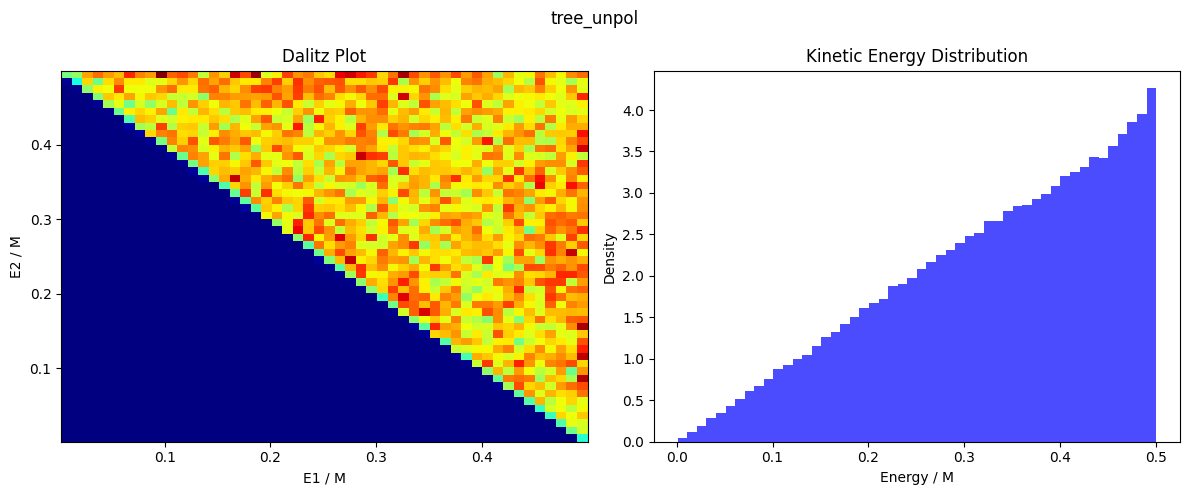

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assume samples is a (N, 2) array of (e1/M, e2/M); e.g., from sample_dalitz
# Example: samples = np.array([[0.3, 0.4], [0.2, 0.5], ...])

def plot_dalitz_and_energy(samples, title='Dalitz Plot and Energy Distribution'):
    # Compute normalized energies (e1_norm, e2_norm, e3_norm = 1 - e1_norm - e2_norm)
    e1_norm = samples[:, 0]
    e2_norm = samples[:, 1]
    e3_norm = 1 - e1_norm - e2_norm

    # Collect all energies for histogram (denormalize by M if needed; here normalized)
    all_energies = np.concatenate([e1_norm, e2_norm, e3_norm])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Dalitz plot (hist2d for density)
    axs[0].hist2d(e1_norm, e2_norm, bins=50, cmap='jet')
    axs[0].set_xlabel('E1 / M')
    axs[0].set_ylabel('E2 / M')
    axs[0].set_title('Dalitz Plot')

    # Kinetic energy distribution (histogram of all E_i / M)
    axs[1].hist(all_energies, bins=50, density=True, alpha=0.7, color='blue')
    axs[1].set_xlabel('Energy / M')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Kinetic Energy Distribution')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage with dummy data (replace with your samples)
samples_dummy = np.loadtxt('samples_tree_unpol.txt')  # Load your samples here
plot_dalitz_and_energy(samples_dummy, title='tree_unpol')

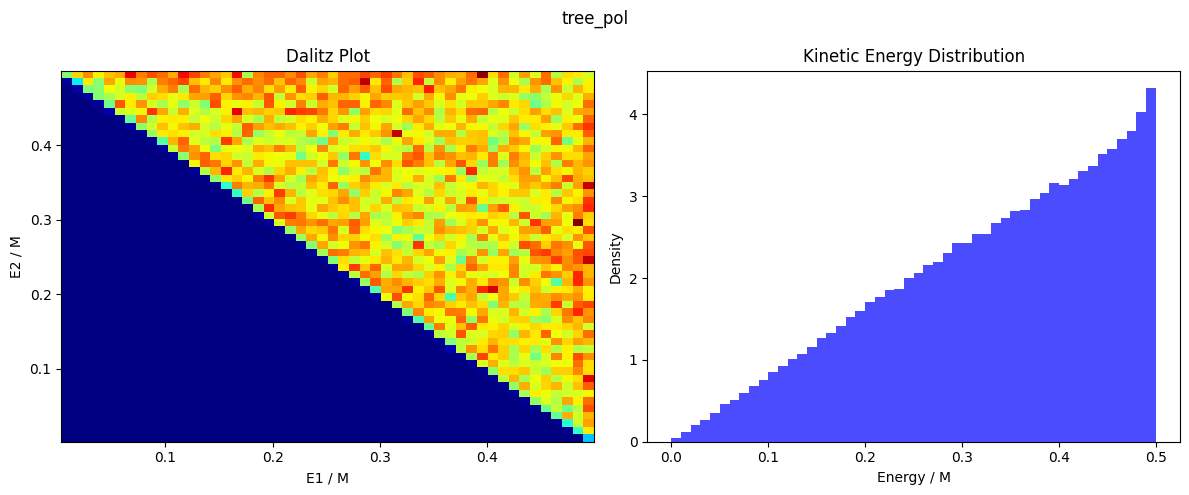

In [17]:
samples_dummy = np.loadtxt('samples_tree_pol.txt')  # Load your samples here
plot_dalitz_and_energy(samples_dummy, title='tree_pol')

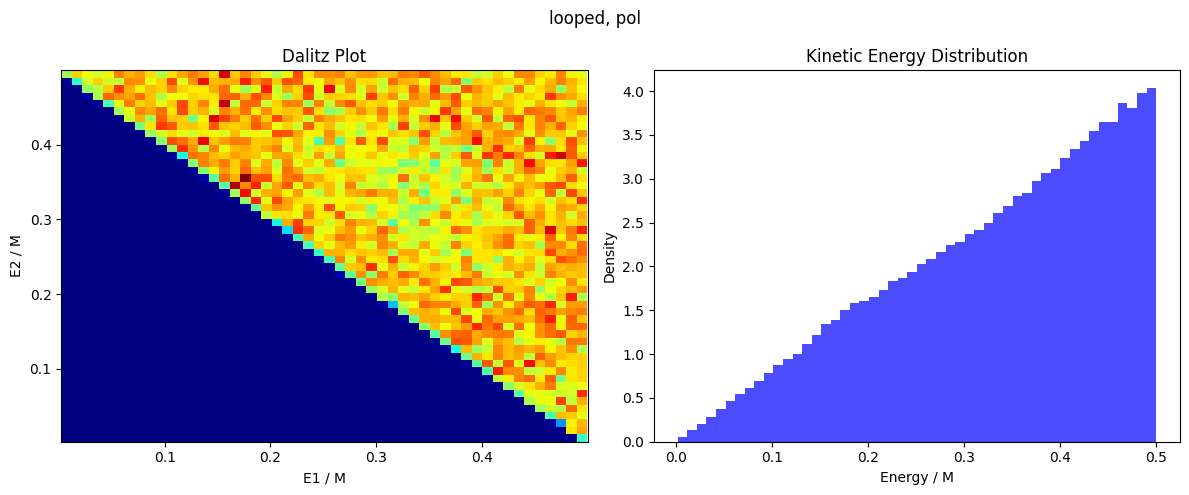

In [18]:
samples_dummy = np.loadtxt('samples_loop_pol.txt')  # Load your samples here
plot_dalitz_and_energy(samples_dummy, title='looped, pol')

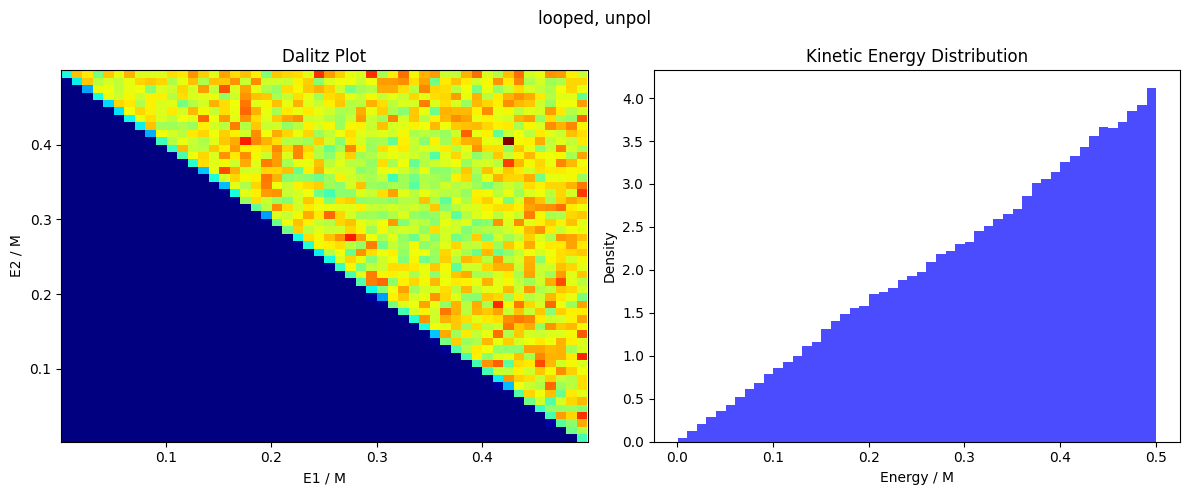

In [19]:
samples_dummy = np.loadtxt('samples_loop_unpol.txt')  # Load your samples here
plot_dalitz_and_energy(samples_dummy, title='looped, unpol')